In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tqdm.notebook import trange

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

# fix random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

## Model specification

## Data

In [3]:
batch_size = 128
lr = 3e-4
log_interval = 10
num_epochs = 15

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

dataset1 = datasets.MNIST("data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("data", train=False, transform=transform)

train_loader = DataLoader(dataset1, batch_size=batch_size)
test_loader = DataLoader(dataset2, batch_size=batch_size)

In [5]:
indexes = dict()
for index, target in enumerate(dataset1.targets.tolist()):
    if target not in indexes:
        indexes[target] = [index]
    else:
        indexes[target].append(index)

In [6]:
subsampled_indexes = dict()
for i in range(10):
    subsampled_indexes[i] = []
subsampled_data = []
subsampled_target = []
for key, sub_indexes in indexes.items():
    np_sub_indexes = np.random.choice(sub_indexes, 50, replace=False)
    subsampled_indexes[key] = np_sub_indexes
    for index in np_sub_indexes:
        data, target = dataset1.__getitem__(index)
        subsampled_data.append(torch.flatten(data))
        subsampled_target.append(target)
    

subsampled_data = torch.stack(subsampled_data)
subsampled_target = torch.tensor(subsampled_target)
subsampled_data.shape, subsampled_target.shape

(torch.Size([500, 784]), torch.Size([500]))

## Basic optimization loop

### 1. Model definition

In [7]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        m: int,
        d_in: int,
        depth: int,
        d_hid: int = 10,
    ) -> None:
        super().__init__()

        assert depth in [2, 3]

        self.encoder = nn.Sequential(
            nn.Linear(d_in, d_hid),
            nn.ReLU(),
        )
        if depth == 3:
            self.encoder.append(nn.Linear(d_hid, d_hid))
            self.encoder.append(nn.ReLU())
        self.encoder.append(nn.Linear(d_hid, m))

        self.decoder = nn.Sequential(
            nn.Linear(m, d_hid),
            nn.ReLU(),
        )
        if depth == 3:
            self.decoder.append(nn.Linear(d_hid, d_hid))
            self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Linear(d_hid, d_in))


    def forward(self, X: Tensor):
        hidden = self.encoder(X)
        out = self.decoder(hidden)


        return out

    def encode(self, X: Tensor):
        return self.encoder(X)

### 2. Associated stuffs' declaration

In [8]:
img_dim = 28

depth = 2
d_hid = 10

model_1 = AutoEncoder(m=2, d_in=img_dim * img_dim, depth=2, d_hid=d_hid).to(device)
model_2 = AutoEncoder(m=3, d_in=img_dim * img_dim, depth=3, d_hid=d_hid).to(device)

criterion = nn.MSELoss()

### 3. Start training

In [9]:
def trigger_train(model: nn.Module, criterion, train_loader: DataLoader) -> list:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    model.train()
    step = 0
    for _ in trange(num_epochs, desc="Epoch"):
        for X, _ in train_loader:
            optimizer.zero_grad()

            X = X.to(device)
            X = X.flatten(start_dim=1)

            out = model(X)

            loss = criterion(X, out)
            loss.backward()
            optimizer.step()

            step += 1
            # if step % log_interval == 0:
            losses.append({
                'step': step,
                'loss_train': loss.item()
            })

    return losses

In [10]:
losses_1 = trigger_train(model_1, criterion, train_loader)
losses_2 = trigger_train(model_2, criterion, train_loader)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

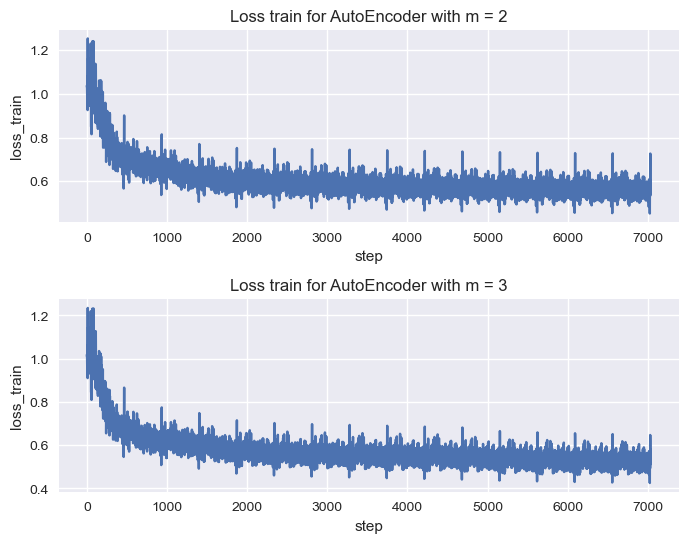

In [11]:
df_loss1 = pd.DataFrame.from_records(losses_1)
df_loss2 = pd.DataFrame.from_records(losses_2)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(211)

sns.lineplot(data=df_loss1, x='step', y='loss_train', ax=ax)
ax.set_title("Loss train for AutoEncoder with m = 2")

ax = fig.add_subplot(212)
sns.lineplot(data=df_loss2, x='step', y='loss_train', ax=ax)
ax.set_title("Loss train for AutoEncoder with m = 3")

plt.subplots_adjust(wspace=0.4, hspace=0.4)

### 4. Extract hidden representations from 2 models

In [12]:
model_1.eval()
model_2.eval()
with torch.no_grad():
    embeddings1 = model_1.encode(subsampled_data.to(device)).detach().cpu().numpy()
    embeddings2 = model_2.encode(subsampled_data.to(device)).detach().cpu().numpy()

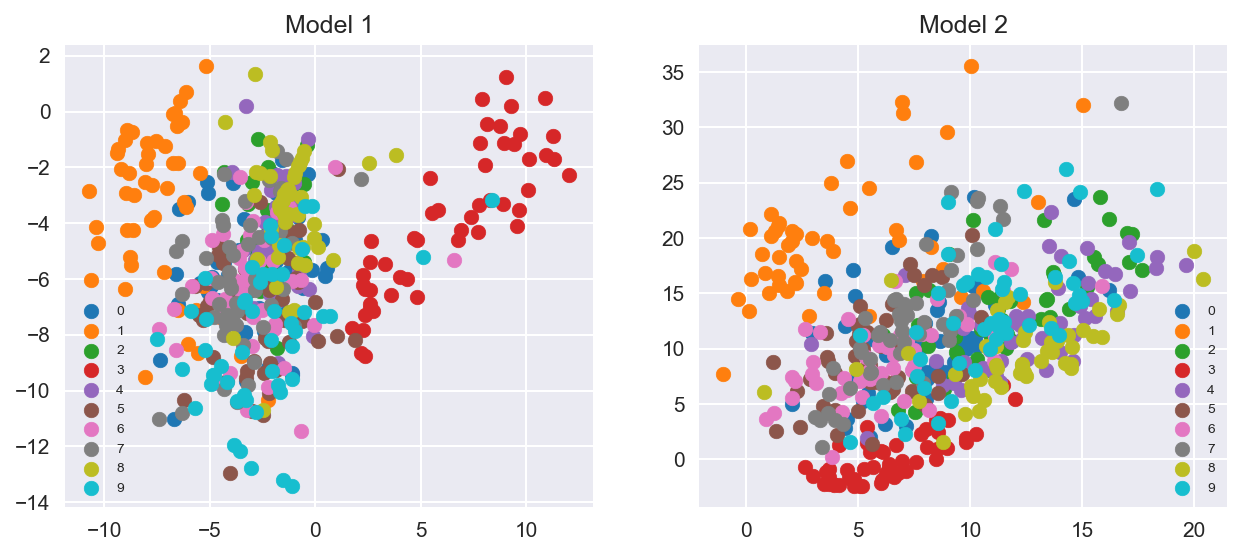

In [13]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 4))
cmap = plt.get_cmap("tab10")
axs[0].set_title("Model 1")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[0].scatter(embeddings1[50*i: 50*(i+1), 0], embeddings1[50*i: 50*(i+1), 1], color=color, label=key)
axs[0].legend(fontsize="small")
axs[1].set_title("Model 2")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[1].scatter(embeddings2[50*i: 50*(i+1), 0], embeddings2[50*i: 50*(i+1), 1], color=color, label=key)
axs[1].legend(fontsize="small")
plt.show()